**Data:**
1. MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ - **275,974 beats** *(Control)* <br></br> 
18 long-term ECG recordings of normal healthy not-arrhythmic subjects(Females = 13; age range: 20 to 50) 


2. BIDMC https://physionet.org/content/chfdb/1.0.0/ - **214,531 beats** *(Intervention)* <br></br>
15 subjects with severe CHF (i.e., NYHA classes III-IV) (Females = 4; age range: 22 to 63)

Total: 490,505 heart-beats

In [1]:
# # Input folders
from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

bidmc-congestive-heart-failure-database-1.0.0
mit-bih-normal-sinus-rhythm-database-1.0.0
processed_data



In [2]:
# # Input files
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/mit-bih-normal-sinus-rhythm-database-1.0.0/16272.atr
data/mit-bih-normal-sinus-rhythm-database-1.0.0/17453.hea
data/mit-bih-normal-sinus-rhythm-database-1.0.0/17453.hea-
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16795.dat
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19140.atr
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16273.atr
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16420.dat
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19090.hea
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19088.dat
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16265.atr
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16773.hea
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19830.xws
data/mit-bih-normal-sinus-rhythm-database-1.0.0/RECORDS
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19093.hea-
data/mit-bih-normal-sinus-rhythm-database-1.0.0/19093.hea
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16483.xws
data/mit-bih-normal-sinus-rhythm-database-1.0.0/16786.dat
data/mit-bih-n

In [2]:
# Import relevant packages

import wfdb
from wfdb import processing
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import shutil
from IPython.display import display 

## 2.2 Preprocessing
1. Downsample BIDMC to 128Hz to fit MIT-BIH
2. Filter for only (N) normal beats
3. Each heartbeat being z-normalised
4. Since each subject has a large amount of up to 70,000 beats, the study extracted a beat every 5s

In [3]:
# directory for dataset
dir1 = 'data/bidmc-congestive-heart-failure-database-1.0.0/'
dir2 = 'data/mit-bih-normal-sinus-rhythm-database-1.0.0/'
df1, df2 = list(), list()

# all the header files from chf dataset
for i in os.listdir(dir1):
    if i.endswith(".hea"):
        df1.append(i)
# all the annotations from normal dataset
for i in os.listdir(dir2):
    if i.endswith(".atr"):
        df2.append(i)        

df1, df2 = pd.DataFrame(df1), pd.DataFrame(df2) 
df_1 = pd.read_csv(dir1+"RECORDS", header=None)
df_2 = pd.read_csv(dir2+"RECORDS", header=None)

In [4]:
df_1.head()

,0
0,chf01
1,chf02
2,chf03
3,chf04
4,chf05


In [5]:
print(df1.head()+" "+df2.head())

                     0
0  chf09.hea 16272.atr
1  chf08.hea 19140.atr
2  chf11.hea 16273.atr
3  chf05.hea 16265.atr
4  chf04.hea 16539.atr


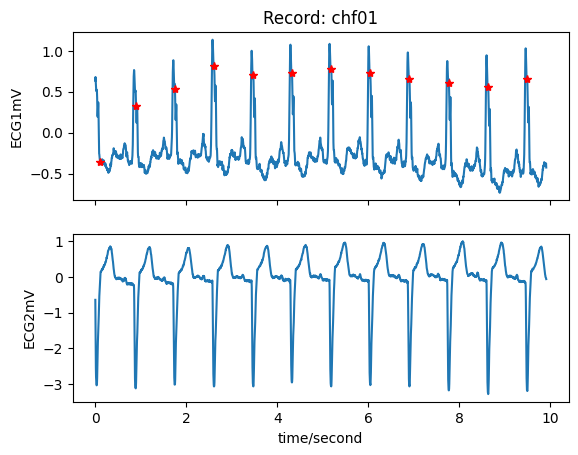

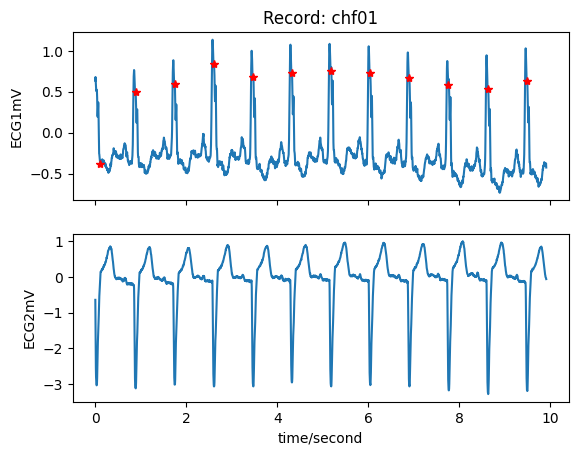

{'record_name': 'chf01',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2480,
 'base_time': datetime.time(10, 0),
 'base_date': None,
 'comments': ['Age: 71  Sex: M  NYHA class: III-IV'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[ 0.635, -0.64 ],
        [ 0.68 , -1.28 ],
        [ 0.63 , -1.92 ],
        ...,
        [-0.4  , -0.02 ],
        [-0.375, -0.045],
        [-0.425, -0.06 ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['chf01.dat', 'chf01.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [127, -128],
 'checksum': [6227, 39918],
 'block_size': [0, 0]}

In [25]:
# Display 1 record and its dictionary (from:100 - to:2100)
record = wfdb.rdrecord(dir1+'chf01', sampfrom=0, sampto=2480)
ann = wfdb.rdann(dir1+'chf01', 'ecg', sampfrom=0, sampto=2480)
wfdb.plot_wfdb(record, ann)

fs = record.fs    
signal = record.p_signal 
fs_target = 128
p_signal, nann = processing.resample_multichan(
    xs=signal, 
    ann=ann, 
    fs=fs, 
    fs_target=fs_target
)
wfdb.plot_wfdb(record, nann)

display(record.__dict__)

In [41]:
display(ann.__dict__)

{'record_name': 'chf01',
 'extension': 'ecg',
 'sample': array([  28,  224,  438,  653,  868, 1081, 1296, 1512, 1726, 1942, 2159,
        2374]),
 'symbol': ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'num': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'aux_note': ['', '', '', '', '', '', '', '', '', '', '', ''],
 'fs': 250,
 'label_store': None,
 'description': None,
 'custom_labels': None,
 'contained_labels': None,
 'ann_len': 12}

In [40]:
r_peak_candidates = [12, 15]
np.median(np.subtract(r_peak_candidates[1:], r_peak_candidates[:-1]))

3.0

In [7]:
len(p_signal)

1679

In [36]:
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

# Sample ECG data (use your provided data)
X = p_signal[:, 0] # Replace '...' with your ECG data
sampling_rate = 12  # Example: 300 Hz
window_size = 10 * sampling_rate  # 10 seconds

# 1. Split the signal into 10s windows
ecg_windows = [X[i:i + window_size] for i in range(0, len(X), window_size)]

# Select the first 10s window for demonstration
ecg_window = ecg_windows[1]

# 2. Normalize the amplitude values between 0 and 1
normalized_ecg = MinMaxScaler().fit_transform(ecg_window.reshape(-1, 1)).flatten()
print(len(normalized_ecg))

# 4. Find R-peak candidates using a threshold of 0.9
r_peak_candidates,_ = find_peaks(x=normalized_ecg, height=0.9, distance=30)
print(r_peak_candidates)

# 5. Compute R-R intervals and median nominal heartbeat period T
T = np.median(np.subtract(r_peak_candidates[1:], r_peak_candidates[:-1]))
print(T)

# 6. Select signal parts of length 1.2T around each R-peak
selected_parts = []
part_length = min(int(1.2 * (T if T == T else 10)), 200)  # Convert seconds to samples
for r_peak in r_peak_candidates:
    start = r_peak
    end = start + part_length
    part = normalized_ecg[start:end]
    selected_parts.append(np.pad(part, (0, fixed_length - len(part)), mode='constant')[:fixed_length])

# 7. Pad each selected part with zeros to a fixed length
selected_parts

120
[99]
nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[array([1.        , 0.96829357, 0.85184953, 0.7902416 , 0.7902987 ,
        0.75829357, 0.5906002 , 0.47119638, 0.56300591, 0.59846781,
        0.39398702, 0.19680369, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [18]:
import numpy as np

np.median(np.subtract(r_peak_candidates[1:], r_peak_candidates[:-1]))

110.0

In [50]:
record = wfdb.rdrecord(dir2+'16265')
ann = wfdb.rdann(dir2+'16265', 'atr', shift_samps=True)
# wfdb.plot_wfdb(record, ann)
display(record.__dict__)
display(ann.__dict__)

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ...,
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

{'record_name': '16265',
 'extension': 'atr',
 'sample': array([       1,       52,      129, ..., 10247715, 10247823, 10247936]),
 'symbol': ['|',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

In [52]:
print(len(ann.sample), len(ann.symbol))

100955 100955


In [57]:
a = np.arange(12) + 1
np.where((a > 2) & (a < 12))

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),)

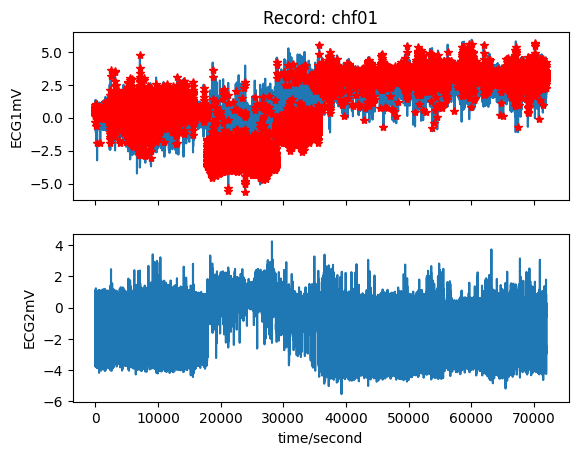

{'record_name': 'chf01',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 17994491,
 'base_time': datetime.time(10, 0),
 'base_date': None,
 'comments': ['Age: 71  Sex: M  NYHA class: III-IV'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[ 0.635, -0.64 ],
        [ 0.68 , -1.28 ],
        [ 0.63 , -1.92 ],
        ...,
        [ 2.265, -0.52 ],
        [ 2.245, -0.5  ],
        [ 2.245, -0.515]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['chf01.dat', 'chf01.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [127, -128],
 'checksum': [17579, 21162],
 'block_size': [0, 0]}

In [9]:
# Display 1 record and its dictionary (full)
# record = wfdb.rdrecord(dir1+'chf01')
# ann = wfdb.rdann(dir1+'chf01', 'ecg')
# wfdb.plot_wfdb(record, ann)
# display(record.__dict__)

Signal length: 2000


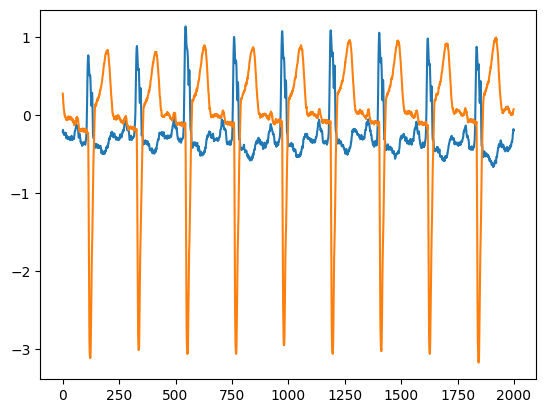

In [13]:
# Sample out signal from record
plt.plot(record.p_signal)
print("Signal length: " + str(len(record.p_signal)))

New frequency sample: 128
New signal length: 2000


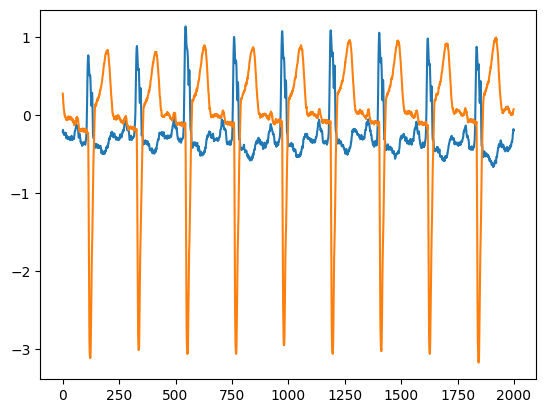

In [17]:
# Downsample to 128 hz
fs = 128
new_sig, new_ann = wfdb.processing.resample_multichan(record.p_signal, ann, record.fs, fs_target = fs)
record.fs = fs # Update record's fs
print("New frequency sample: " + str(record.fs))
plt.plot(new_sig)
print("New signal length: " + str(len(new_sig))) 

The average is -0.14023500000000003and the std is 0.5981276262429281


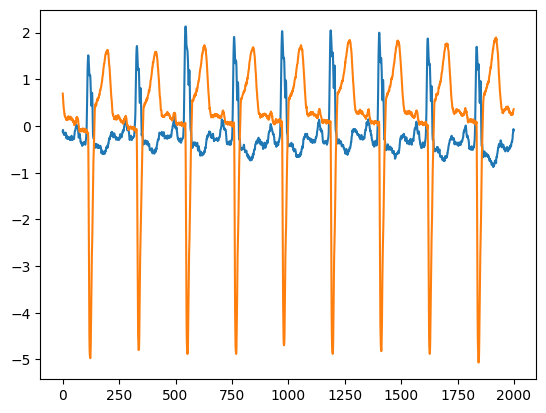

In [18]:
# Z-normalise
avg = new_sig.mean() # Count Mean once
sd = new_sig.std() # Count SD once
print("The average is " + str(avg) + "and the std is " + str(sd))
new_sig = (new_sig - avg)/(sd)
plt.plot(new_sig);

New signal length: 205


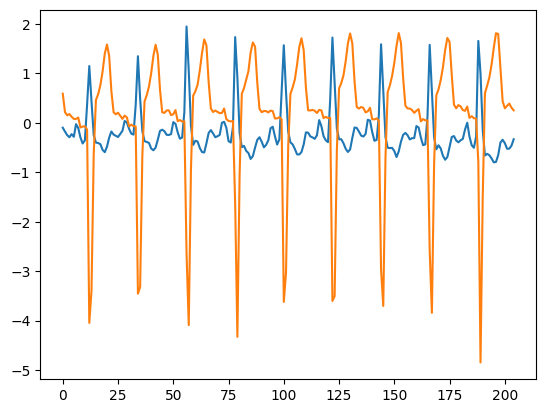

In [16]:
# Extracting a beat every 5s (Incorrect way)
# new_sig = new_sig[::5]
# print("New signal length: " + str(len(new_sig)))
# plt.plot(new_sig);

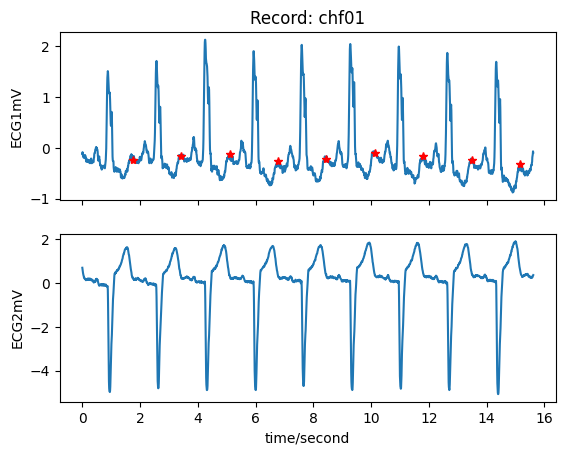

{'record_name': 'chf01',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2000,
 'base_time': datetime.time(10, 0, 0, 400000),
 'base_date': None,
 'comments': ['Age: 71  Sex: M  NYHA class: III-IV'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.11663899,  0.69422475],
        [-0.08320131,  0.60227113],
        [-0.11663899,  0.55211461],
        ...,
        [-0.12499841,  0.33476969],
        [-0.06648247,  0.34312911],
        [-0.09156073,  0.35984795]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['chf01.dat', 'chf01.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-42, 55],
 'checksum': [37420, 47000],
 'block_size': [0, 0]}

In [19]:
# Update with pre-processed signal
record.p_signal = new_sig
record.sig_len = len(new_sig)
wfdb.plot_wfdb(record, new_ann)
display(record.__dict__)

# Need to find a way to extract (N) heartbeats via annotations 

9
[ 223  654 1085 1517 1942 2372 2803 3234 3667]
223 654


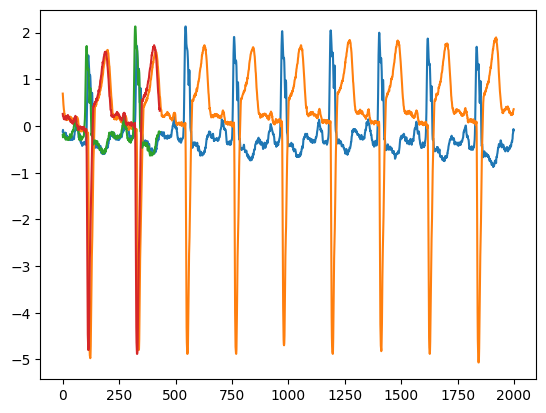

In [20]:
# qrs = wfdb.processing.XQRS(record.p_signal[0], record.fs)
peak_indices = wfdb.processing.gqrs_detect(record.p_signal, record.fs)
# wfdb.processing.compute_hr(record.sig_len, peak_indices, record.fs)
print(len(peak_indices))
print(peak_indices)
print(peak_indices[0], peak_indices[1])
plt.plot(record.p_signal);
plt.plot(record.p_signal[(peak_indices[0]):(peak_indices[1])]);
# plt.plot(record.p_signal[(peak_indices[0]-30):(peak_indices[0]+50)]); # 30 samples before, 50 samples after
# Figure out how to train with all these beats

In [21]:
wfdb.io.show_ann_labels()
wfdb.io.show_ann_classes()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [23]:
# Batch pre-process
list1 = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']
for i in list1:
  sig, fields = wfdb.rdsamp(dir1+"chf{}".format(i))
  ann = wfdb.rdann(dir1+'chf{}'.format(i), 'ecg')
  new_sig, new_ann = wfdb.processing.resample_multichan(sig, ann=ann, fs=fields['fs'], fs_target=128) # Downsample to 128 hz
  avg = new_sig.mean() # Count Mean once
  sd = new_sig.std() # Count SD once
  new_sig = (new_sig - avg)/(sd) # Z-normalise
  # Extracting a beat every 5s?
  # Filter for normal beats?
  np.savetxt("CHF{}_sig.csv".format(i), new_sig, delimiter=",")
  np.savetxt("CHF{}_ann.csv".format(i), new_sig, delimiter=",")
  print("Processing signal of " + str(i) + " / " + str(len(list1)) + "...")

KeyboardInterrupt: 

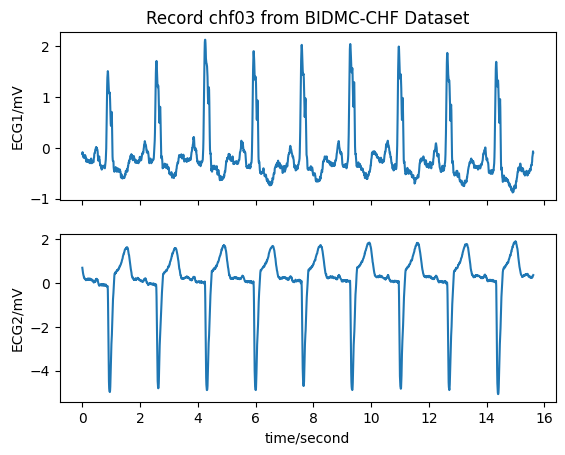

{'record_name': 'chf01',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2000,
 'base_time': datetime.time(10, 0, 0, 400000),
 'base_date': None,
 'comments': ['Age: 71  Sex: M  NYHA class: III-IV'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.11663899,  0.69422475],
        [-0.08320131,  0.60227113],
        [-0.11663899,  0.55211461],
        ...,
        [-0.12499841,  0.33476969],
        [-0.06648247,  0.34312911],
        [-0.09156073,  0.35984795]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['chf01.dat', 'chf01.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-42, 55],
 'checksum': [37420, 47000],
 'block_size': [0, 0]}

In [24]:
# Downsample from 250mhz

for file in os.listdir(dir1):
    if i.endswith(".hea"):
        with open(file) as records:
            i = wfdb.rdrecord(records)
            new_sig = wfdb.processing.resample_sig(i, 250, 128)
            new_ann = wfdb.processing.resample_ann(i, 250, 128)
            record = wfdb.rdrecord(i)

wfdb.plot_wfdb(record=record, title='Record chf03 from BIDMC-CHF Dataset') # Plot
display(record.__dict__) # Annotations

# Possibly useful functions

/var/folders/tp/xhg0_2r975dcj4cmr1zw6mbc0000gn/T/ipykernel_35844/661401956.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
/var/folders/tp/xhg0_2r975dcj4cmr1zw6mbc0000gn/T/ipykernel_35844/661401956.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)


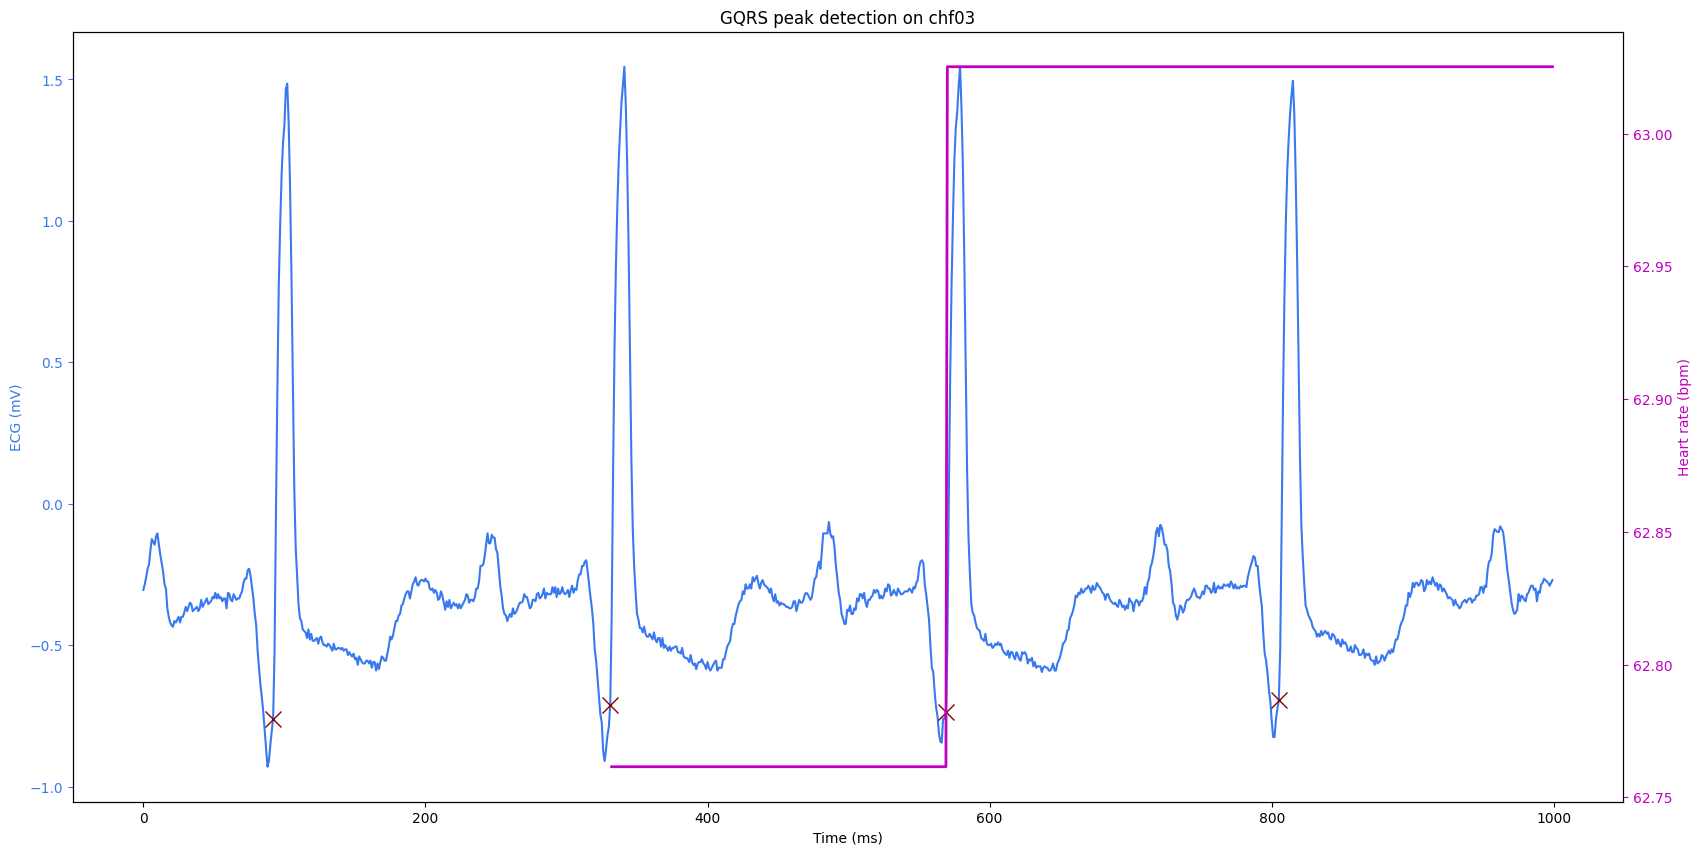

Corrected gqrs detected peak indices: [102, 341, 579, 815]


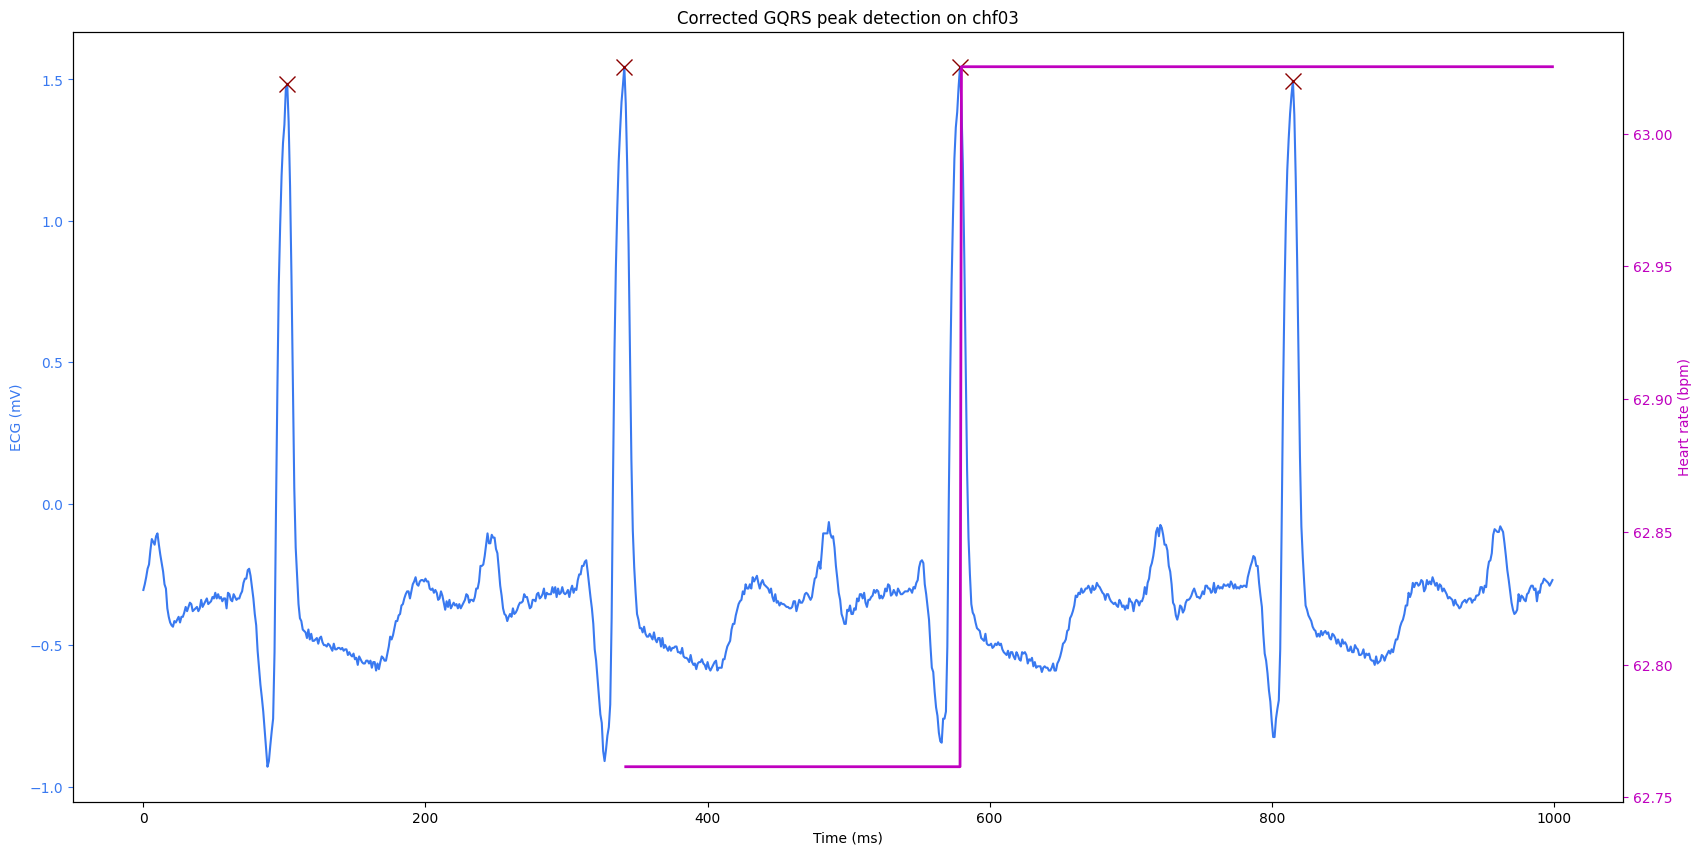

In [30]:
# Use the gqrs detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the wfdb record and the physical samples
record = wfdb.rdrecord(dir1+'chf03', sampfrom=0, sampto=1000, channels=[1])

# Use the gqrs algorithm to detect qrs locations in the first channel
qrs_inds = processing.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
        title="GQRS peak detection on chf03")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.correct_peaks(record.p_signal[:,0], peak_inds=qrs_inds,
                                               search_radius=search_radius, smooth_window_size=150)

# Display results
print('Corrected gqrs detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on chf03")

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
5 reference annotations, 6 test annotations

True Positives (matched samples): 5
False Positives (unmatched test samples): 1
False Negatives (unmatched reference samples): 0

Sensitivity: 1.0000 (5/5)
Positive Predictivity: 0.8333 (5/6)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wfdb/processing/evaluate.py:403: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


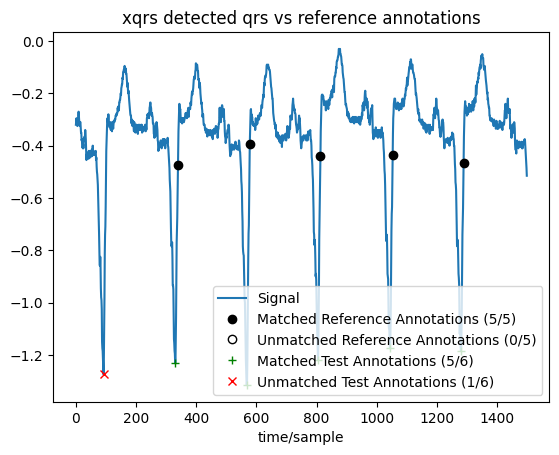

In [31]:
# Use xqrs detection algorithm and compare against reference annotations
sig, fields = wfdb.rdsamp(dir1+'chf03', channels=[0], sampto=1500)
ann_ref = wfdb.rdann(dir1+'chf03','ecg', sampto=1500)

# Run qrs detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the qrs indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected qrs complexes to reference annotation.
# Note, first sample in 100.atr is not a qrs.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected qrs vs reference annotations')

In [32]:
def beat_annotations(annotation):
    """ Get rid of non-beat markers """
    """'N' for normal beats. Similarly we can give the input 'L' for left bundle branch block beats. 'R' for right bundle branch block
        beats. 'A' for Atrial premature contraction. 'V' for ventricular premature contraction. '/' for paced beat. 'E' for Ventricular
        escape beat."""
    
    good = ['N']   
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]

    return beats

def segmentation(records):
    Normal = []
    for e in records:
        signals, fields = wfdb.rdsamp(e, channels = [0]) 
        ann = wfdb.rdann(e, 'atr')
        good = ['N']
        ids = np.in1d(ann.symbol, good)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in imp_beats:
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                x = beats[j-1]
                y = beats[j+1]
                diff1 = abs(x - beats[j])//2
                diff2 = abs(y - beats[j])//2
                Normal.append(signals[beats[j] - diff1: beats[j] + diff2, 0])
    return Normal